# Sample solutions

In [2]:
%matplotlib inline
%load_ext memory_profiler
import numpy as np
from scipy import sparse
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib as mpl
from yellowbrick.style import rcmod
from scipy.stats import spearmanr
from memory_profiler import profile

In [4]:
# Yellowbrick changes the plotting settings, reset to default here
rcmod.reset_orig()

# Problem 1

1. Load the data

In [9]:
X = np.load("data/p1/X.npy")
y = np.load("data/p1/y.npy")

In [6]:
# 511 cells, 45768 genes
print(X.shape)

(511, 45768)


In [11]:
# 511 labels
print(y.shape) 

(511,)


In [12]:
# Largest entry of first column
np.max(X[:,0])

11.941397591320595

2. Log transform

In [7]:
# Log 
X_log = np.log2(X + 1)

In [7]:
# Largest entry of first column
print(np.max(X_log[:,0]))

3.6939215228197613


3. Full PCA, raw vs transformed data

In [8]:
%%timeit -n 1 -r 1
%%memit -r 1
pca = PCA().fit(X)
pca_log = PCA().fit(X_log)

peak memory: 1429.69 MiB, increment: 951.43 MiB
10.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
# Percentage of variance explained by first component
print("First component raw:", pca.explained_variance_ratio_[0])
print("First component log:", pca_log.explained_variance_ratio_[0])

First component raw: 0.42779670983572665
First component log: 0.13887564870826177


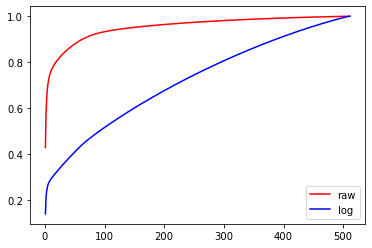

In [11]:
# Cumulative variance explained plots
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca.explained_variance_ratio_), color="red", label="raw")
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca_log.explained_variance_ratio_), color="blue", label="log")
plt.legend()
plt.show()

In [12]:
# 85% variance cutoffs
print("Raw:", np.where(np.cumsum(pca.explained_variance_ratio_) >= .85)[0][0] + 1)
print("Log:", np.where(np.cumsum(pca_log.explained_variance_ratio_) >= .85)[0][0] + 1)

Raw: 36
Log: 339


4. Plotting without visualization techniques

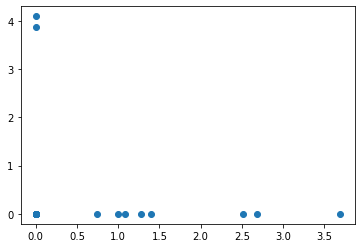

In [13]:
# Nothing informative!
plt.scatter(X_log[:,0],X_log[:,1])

5. PCA visualization

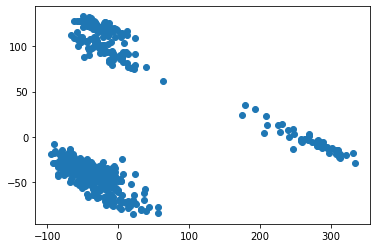

In [14]:
# Three visually distinct clusters. Could potentially argue for 4 or 5 as well, but these are not well-separated
z = pca_log.transform(X_log)
plt.scatter(z[:,0],z[:,1])

6. MDS (sklearn version is nonlinear)

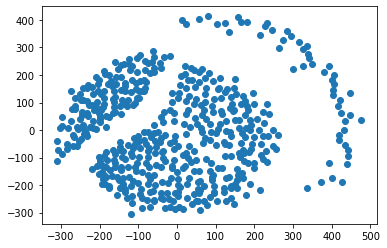

In [15]:
# We still see 3 distinct clusters.
mds=MDS(n_components=2).fit_transform(X_log)
plt.scatter(mds[:,0],mds[:,1])

7. T-SNE

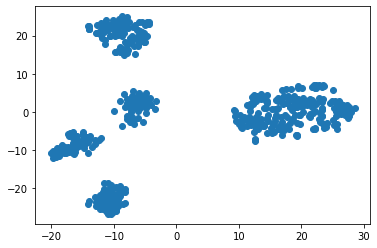

In [16]:
# Emergence of at least 5 clusters. 
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1])

8. K-Means

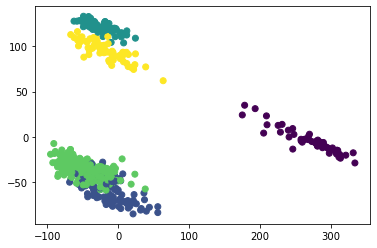

In [17]:
# 5 clusters: PCA plot
kmeans = KMeans(5, tol=1e-6)
kmeans.fit(z[:,0:50])
plt.scatter(z[:,0],z[:,1], c=kmeans.labels_)

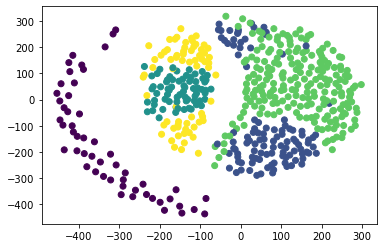

In [24]:
# 5 clusters: MDA with K means plot
plt.scatter(mds[:,0],mds[:,1],c=kmeans.labels_)

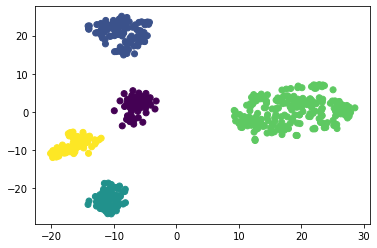

In [18]:
# T-SNE plot
plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)

9. Elbow method.

Num clusters 2 Inertia: 9520809.578746
Num clusters 3 Inertia: 7257882.201193228
Num clusters 4 Inertia: 6202929.841899466
Num clusters 5 Inertia: 5801585.180913827
Num clusters 6 Inertia: 5561682.44813587
Num clusters 7 Inertia: 5398373.909889216
Num clusters 8 Inertia: 5244358.318708705
Num clusters 9 Inertia: 5218512.976946919


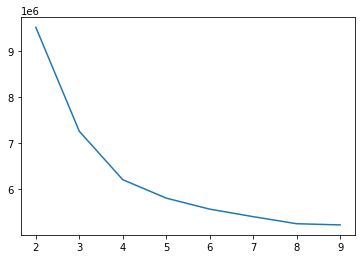

In [19]:
# Would select 3, 4, or 5 clusters
all_kmeans = [i for i in range(8)]
for i in range(8):
    cur_kmeans = KMeans(i+2)
    cur_kmeans.fit(z[:,0:50])
    print("Num clusters", i+2, "Inertia:", cur_kmeans.inertia_)
    all_kmeans[i] = cur_kmeans
plt.plot([i+2 for i in range(8)], [all_kmeans[i].inertia_ for i in range(8)])

10. Hierarchical clustering: Dendrogram in R script

11. MDS on cluster means. Confirms 3 groups, one with 1 cluster and two with 2 clusters each. Accurate representation of distances - one cluster is far away from others, indicating a different type of cell. But T-SNE consistently puts it in the middle of the plot.

In [20]:
# MDS on kmeans cluster means
cmeans = np.zeros((5,X_log.shape[1]))
for c in range(5):
    cmeans[c] = np.mean(X_log[np.where(kmeans.labels_==c)[0]],axis=0)

breaking at iteration 98 with stress 6342.534572033932
breaking at iteration 166 with stress 6080.44123860059
breaking at iteration 95 with stress 6342.512244781481
breaking at iteration 105 with stress 6079.000721967379


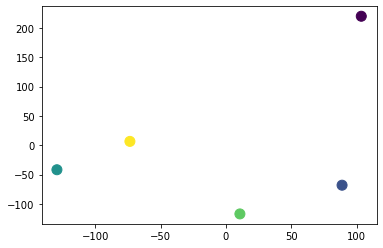

In [21]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(cmeans)
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1],c=[0,1,2,3,4],s=100)

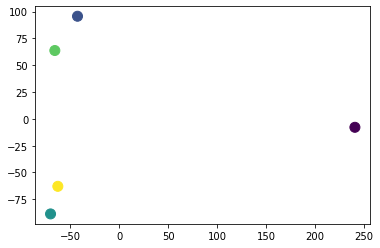

In [22]:
# PCA on cluster means
z_means = PCA(2).fit_transform(cmeans)
plt.scatter(z_means[:,0],z_means[:,1],c=[0,1,2,3,4],s=100)

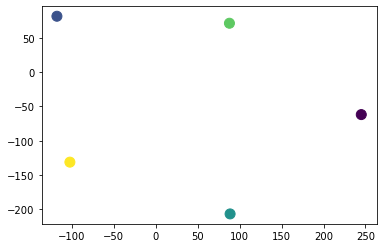

In [26]:
# Emergence of at least 5 clusters. 
z_means_tsne = TSNE(n_components=2,perplexity=40).fit_transform(cmeans)
plt.scatter(z_means_tsne[:,0],z_means_tsne[:,1],c=[0,1,2,3,4],s=100)

12. PCA/T-SNE on Raw Data

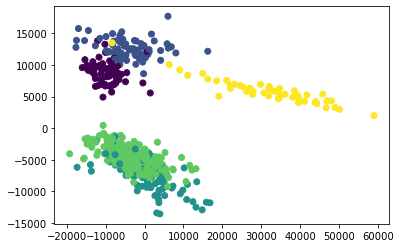

In [32]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1],c=y)

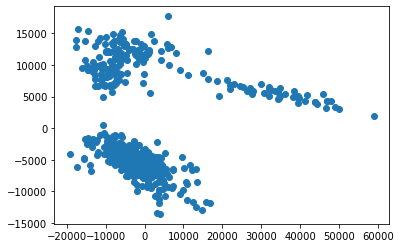

In [33]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1])

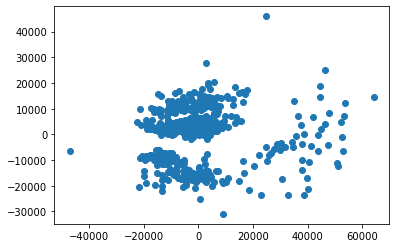

In [31]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(z[:,0:50])
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1])

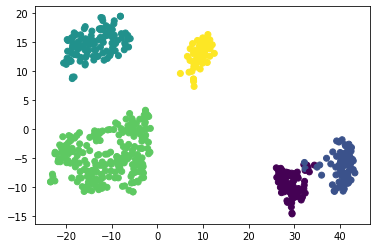

In [28]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)

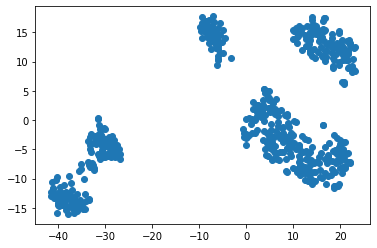

In [34]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1])

# Problem 2

## Part 1: Visualization

In [38]:
X = np.load("data/p2_unsupervised/X.npy")
X = np.log2(X + 1)

In [43]:
n_pcs = 50
pca = PCA(n_components=n_pcs).fit(X)
z = pca.transform(X)

1. Three cell types.  Both PCA and MDS plots below show 3 distinct clusters,corresponding to inhibitory or excitatory neurons, and non-neuronal cells.

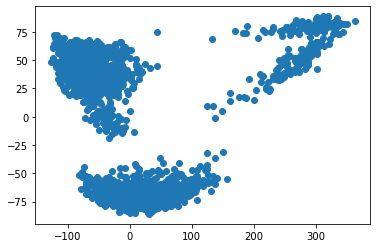

In [42]:
# Three distinct clusters, corresponding to inhibitory or excitatory neurons, and non-neuronal cells.
plt.scatter(z[:,0],z[:,1])

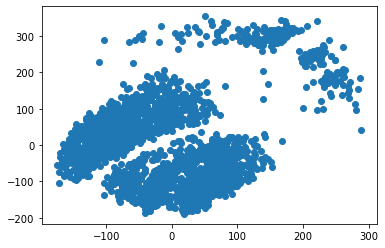

In [45]:
#MDS on the first 50 PCs
mds=MDS(n_components=2).fit_transform(z[:,0:50])
plt.scatter(mds[:,0],mds[:,1])

2. Cell sub-types. Dendrogram provided in R.  In the t-SNE plot below, we see many (more than 3) disinct clusters.  To show that these correspond to cell-subtypes, we create cluster labels using hierarchical clusters with 30 clusters, and replot the PCA visualization with different colors showing the 30 different labels.  This plot shows that these smaller clusters correspond to cell-subtypes that belong to the 3 bigger cell groups.  (The number of clusters are based on inspection of the t-SNE plot for now.  Later on, we will use the average score to justify the number of the smaller clusters/sub-types.)

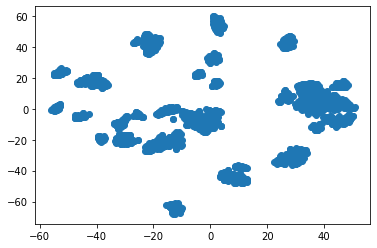

In [26]:
# There are many cell sub-types, as shown here.
z_tsne = TSNE(n_components=2,perplexity  =40).fit_transform(z)
plt.scatter(z_tsne[:,0],z_tsne[:,1])

In [27]:
# Hierarchical clustering shows the cell types. By inspection of the t-SNE plot, we guessed 30 clusters for the current exploration.  Below, we will use the Silouett scores to choose the right number of clusters.  We see the the label from hierachical clustering does correspond roughly to the T-SNE clusters. 
slc = AgglomerativeClustering(n_clusters=30,linkage="ward")
predictions=slc.fit_predict(z)

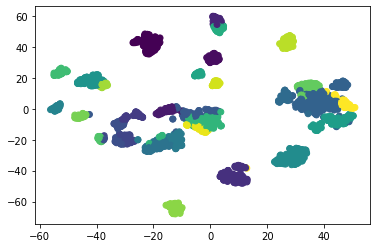

In [46]:
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=predictions)

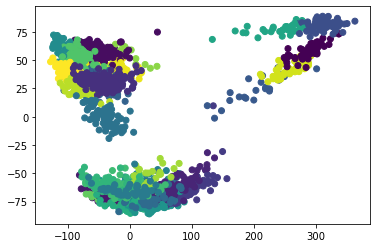

In [19]:
# The 30 cell-subtypes are within each of the 3 big clusters.
#(TODO: color code by region, warmer colors in one cluster and darker colors in the other.)
plt.scatter(z[:,0],z[:,1],c=predictions)

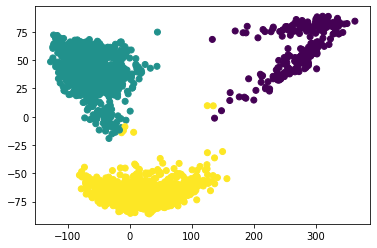

In [13]:
# Use kmeans to fit the 3 classes of cells
kmeans = KMeans(n_clusters=3)
kmeans.fit(z)
plt.scatter(z[:,0],z[:,1],c=kmeans.labels_)

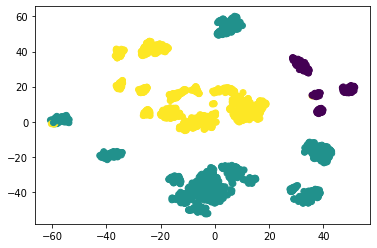

In [14]:
# TSNE visualization with kmeans labels. TSNE on its own does not show the hierarchical structure well.
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=kmeans.labels_)

# Unsupervised feature selection

## Clustering

We plot the mean silhouett score versus the number of clusters below, and use the number of clusters (29) for which the mean silhouett score is maximum. The T-SNE visualization also supports there are numerous clusters.

0
5
10
15
20
25
30
35


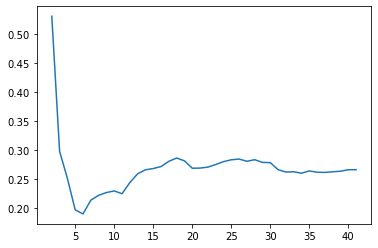

In [28]:
# Hierarchical clustering for many values of k. Means silhouette scores plotted below.
all_slc = [i for i in range(45)]
for i in range(40):
    if i % 5==0:
        print(i)
    slc = AgglomerativeClustering(n_clusters=i+2, linkage="ward")
    slc.fit(z)
    all_slc[i] = slc
plt.plot([i+2 for i in range(40)], [silhouette_score(z[:,0:50],all_slc[i].labels_) for i in range(40)])

In [6]:
# Top silhouette score as a heuristic for number of clusters. Ignore first two entries because we want more clusters
best_index = 2 + np.argmax([silhouette_score(z,all_slc[i].labels_) for i in range(2,40)])
# Number of clusters is index + 2
print("Number of clusters:",best_index+2)

Number of clusters: 29


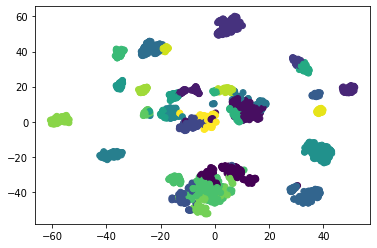

In [15]:
# Visually looks like there should be many clusters.
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=all_slc[best_index].labels_)

In [16]:
labels = all_slc[best_index].labels_

## Logistic regression

In [29]:
# Standardize the data
X_centered = X - np.mean(X,axis=0)
locs_nz = np.where(np.std(X_centered,axis=0)>0)[0]
X_standardized = X_centered
X_standardized[:,locs_nz] /= np.std(X_centered[:,locs_nz],axis=0)

Logistic regression takes about 20 min and 2.5GB memory on standardized, 10 min and 1.25GB memory for original
(Possibly due to sparsity of original matrix)

In [41]:
%%timeit -n 1 -r 1
%%memit -r 1
# Logistic regression for feature selection with cross-validation. Takes about 7 min, 1.24 GB extra memory
lr = LogisticRegressionCV(penalty="l1",solver="liblinear",Cs=[.1,1,10],cv=3)
lr.fit(X, labels)

peak memory: 4524.10 MiB, increment: 1233.25 MiB
7min 20s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [54]:
%%timeit -n 1 -r 1
%%memit -r 1
# Logistic regression for feature selection with cross-validation. Takes about 7 min, 1.24 GB extra memory
lr_sd = LogisticRegressionCV(penalty="l1",solver="liblinear",Cs=[.1,1,10],cv=3)
lr_sd.fit(X_standardized, labels)

peak memory: 5660.42 MiB, increment: 2358.23 MiB
19min 43s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [71]:
with open("log_reg_standardized.pkl", "wb") as f:
    pickle.dump(lr_sd, f)

In [46]:
with open("log_reg.pkl", "wb") as f:
    pickle.dump(lr, f)

In [57]:
lr_sd.score(X_standardized,labels)

1.0

## Feature selection and validation

Features without standardizing

In [44]:
# Get top 100 features by taking features with the largest magnitude coefficients
coef_abs = np.abs(lr.coef_)
max_coefs = np.max(coef_abs,axis=0)
features=np.argpartition(max_coefs, -100)[-100:]
features_log_reg=features

Features with standardizing

In [73]:
# Get top 100 features by taking features with the largest magnitude coefficients
coef_abs = np.abs(lr_sd.coef_)
max_coefs = np.max(coef_abs,axis=0)
features_std=np.argpartition(max_coefs, -100)[-100:]

Evaluation set

In [20]:
# Evaluate features by training a logistic regression model on the training, evaluate on test.
X_train = np.load("data/p2_evaluation/X_train.npy")
y_train = np.load("data/p2_evaluation/y_train.npy")
X_test = np.load("data/p2_evaluation/X_test.npy")
y_test = np.load("data/p2_evaluation/y_test.npy")

In [21]:
# Preprocess
X_train = np.log2(X_train + 1)
X_test = np.log2(X_test + 1)

In [76]:
# Standardizing
means = np.mean(X_train,axis=0)
X_train_centered = X_train - means
sds = np.std(X_train_centered,axis=0)
locs_nz_train = np.where(sds>0)[0]
X_train_standardized = X_train_centered
X_train_standardized[:,locs_nz_train] /= sds[locs_nz_train]

In [77]:
X_test_standardized = X_test - means
X_test_standardized[:,locs_nz_train] /= sds[locs_nz_train]

Evaluation (features from un-standardized data)

In [39]:
%%timeit -n 1 -r 1
%%memit -r 1
# Train on the evaluation training data, evaluate score on test set
lr2 = LogisticRegressionCV(penalty="l2",solver="liblinear",Cs=[.001,.1,1,5,10,50,100],cv=5).fit(X_train[:,features],y_train)

peak memory: 1848.12 MiB, increment: 2.56 MiB
7.03 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [40]:
# Score of this feature selection method (unstandardized)
lr2.score(X_test[:,features],y_test)

0.9034296028880866

Evaluation (features from standardized data)

In [65]:
%%timeit -n 1 -r 1
%%memit -r 1
# Standarization
# Train on the evaluation training data, evaluate score on test set
lr2 = LogisticRegressionCV(penalty="l2",solver="liblinear",Cs=[.001,.1,1,5,10,50,100],cv=5).fit(X_train[:,features],y_train)

peak memory: 3253.73 MiB, increment: 3.56 MiB
15.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [66]:
# Score of this feature selection method
lr2.score(X_test_standardized[:,features_std],y_test)

0.8619133574007221

Variance + random feature baseline

In [68]:
# High-variance feature selection performs well here.
variances = np.var(X, axis=0)
v_features=np.argpartition(variances, -100)[-100:]
lr3 = LogisticRegressionCV(penalty="l2",solver="liblinear",Cs=[1,3,5,10]).fit(X_train[:,v_features],y_train)
lr3.score(X_test[:,v_features],y_test)

0.9268953068592057

In [182]:
%%time
# Random feature baseline. Repeat several times
rf_scores = np.zeros(5)
for i in range(5):
    random_features = np.random.choice(np.arange(X.shape[1]), size=100,replace=False)
    lr4 = LogisticRegressionCV(penalty="l2",solver="liblinear",Cs=[1,3,5,10]).fit(X_train[:,random_features],y_train)
    # Score of this features selection method
    rf_scores[i] = lr4.score(X_test[:,random_features],y_test)
    print("Finished {0}".format(i))

Finished 0
Finished 1
Finished 2
Finished 3
Finished 4
Wall time: 26.1 s


In [183]:
# Random features perform poorly according to this metric
print(rf_scores)

[0.3601083  0.28610108 0.36281588 0.46119134 0.49277978]


Logistic regression chose features which were not all highest variance

In [69]:
# Features selected, which were not highest variance features
np.setdiff1d(features,v_features)

array([  799,  1333,  2533,  2857,  2914,  3073,  3153,  3154,  3669,
        3962,  4193,  4357,  4460,  4545,  4617,  4663,  4866,  5435,
        5597,  5622,  5780,  5810,  5866,  5908,  6009,  6071,  6077,
        6942,  7843,  8200,  8464,  8840, 10426, 13688, 15051, 15529,
       16250, 20714, 21199, 23566, 25861, 27823, 29441, 30220, 30514,
       31444, 31645, 31904, 32209, 33811, 33852, 34456, 34467, 34563,
       34833, 34859, 34955, 34964, 35062, 36701, 36778, 36803, 36855,
       37456, 37689, 38278, 38358, 39126, 39165, 39450, 39612, 39709,
       39711, 39932, 39936, 39948, 40305, 40310, 40437, 40471, 40475,
       40638, 40738, 41225, 41774, 41860, 41898, 42476, 42670, 42860,
       44086, 44796, 44910, 44927, 44956], dtype=int64)

(array([30., 12., 12., 10.,  9.,  5.,  4.,  3.,  3.,  3.,  1.,  2.,  0.,
         3.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([12.16666627, 13.02739087, 13.88811548, 14.74884009, 15.60956469,
        16.4702893 , 17.33101391, 18.19173851, 19.05246312, 19.91318773,
        20.77391233, 21.63463694, 22.49536155, 23.35608615, 24.21681076,
        25.07753537, 25.93825997, 26.79898458, 27.65970919, 28.52043379,
        29.3811584 ]),
 <BarContainer object of 20 artists>)

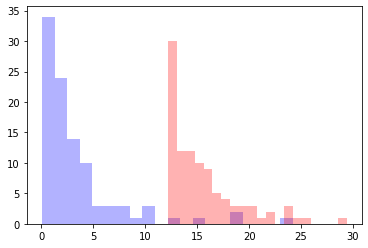

In [70]:
# Histograms of variances of the features selected
plt.hist(variances[features],color="blue",alpha=0.3,bins=20)
plt.hist(variances[v_features],color="red",alpha=0.3,bins=20)

# Problem 3: Hyper-parameter exploration

## TSNE on 10, 50, 100, 250, 500 pc's
Clustering is most clear when using fewer pc's. But using 500 pc's gives a more accurate representation of the distances.

In [78]:
X = np.load("data/p1/X.npy")
y = np.load("data/p1/y.npy")

In [79]:
X = np.log2(X+1)

In [83]:
%%timeit -n 1 -r 1
%%memit -r 1
pca = PCA().fit(X)

peak memory: 3459.44 MiB, increment: 544.97 MiB
10.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [84]:
z=pca.transform(X)

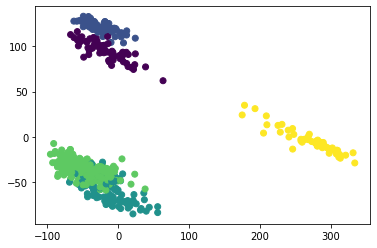

In [88]:
plt.scatter(z[:,0],z[:,1],c=y)

Fewer PC's tend to show the clusters more clearly. If we use many PC's, the clusters tend to merge together. 
For example, 100 and 250 PCs, the yellow cluster blends with some of the other clusters.
Using 500 PCs yields something qualitatively similar to the PCA plot.

Number of PCs: 10


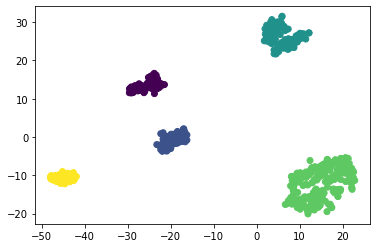

Number of PCs: 50


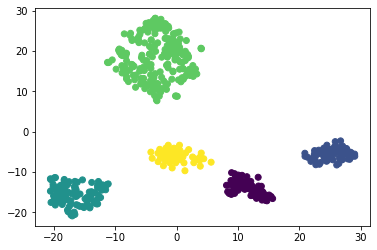

Number of PCs: 100


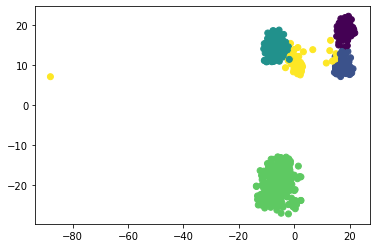

Number of PCs: 250


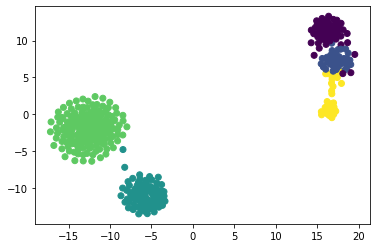

Number of PCs: 500


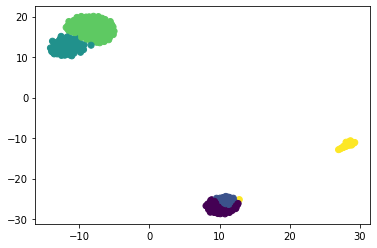

In [89]:
for n_pcs in [10,50,100,250,500]:
    print("Number of PCs:", n_pcs)
    z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:n_pcs])
    plt.scatter(z_tsne[:,0],z_tsne[:,1], c=y)
    plt.show()

# Effect of Perplexity

Using 50 PCs. Aside from very low values of perplexity, the visualizations tend to have the same 5 distinct clusters.
Number of clusters seems to be robust across different perplexities

Perplexity: 5


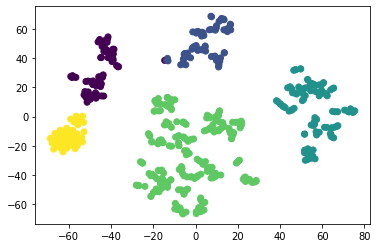

Perplexity: 10


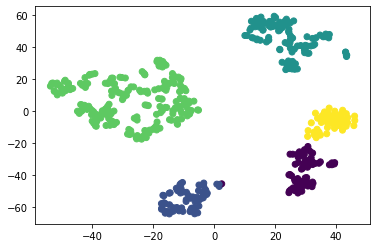

Perplexity: 20


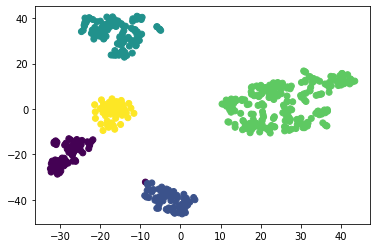

Perplexity: 30


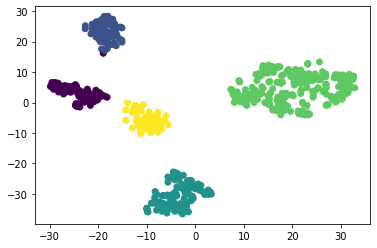

Perplexity: 40


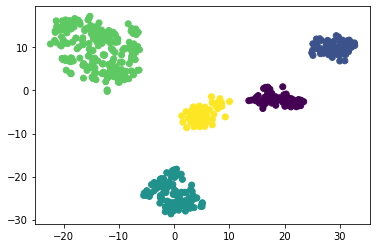

Perplexity: 50


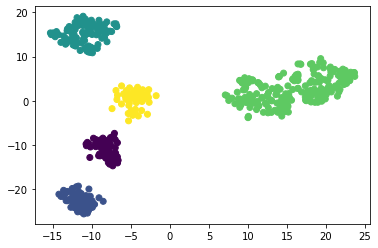

Perplexity: 60


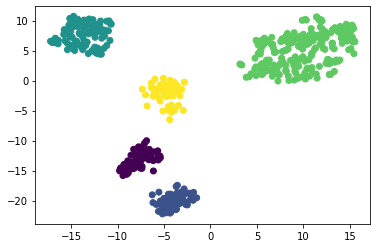

In [90]:
for perplexity in [5,10,20,30,40,50,60]:
    print("Perplexity:", perplexity)
    z_tsne = TSNE(n_components=2,perplexity=perplexity).fit_transform(z[:,0:50])
    plt.scatter(z_tsne[:,0],z_tsne[:,1], c=y)
    plt.show()

Using 100 PCs. In above plots we saw that 100 PCs resulted in a relatively uninformative T-SNE plot. Low values of perplexity create many outlier points. Higher levels of perplexity create more clustered images, but is still not as good as using lower dimension for PCA. T-SNE seems to be sensitive to issues associated with high dimensions.

Perplexity: 5


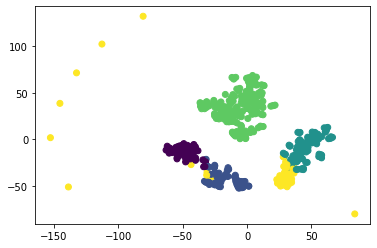

Perplexity: 20


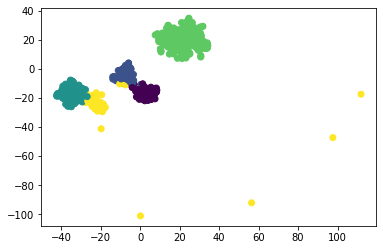

Perplexity: 40


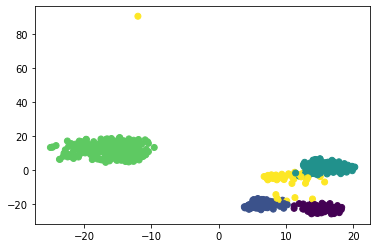

Perplexity: 60


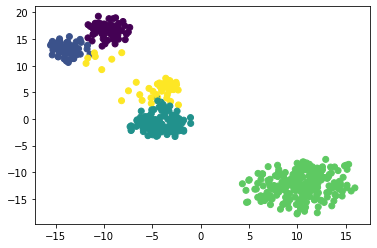

Perplexity: 100


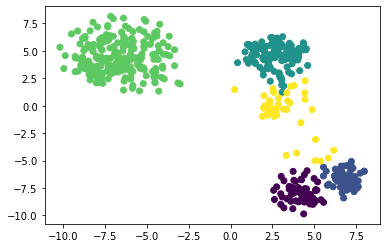

In [92]:
for perplexity in [5,20,40,60,100]:
    print("Perplexity:", perplexity)
    z_tsne = TSNE(n_components=2,perplexity=perplexity).fit_transform(z[:,0:100])
    plt.scatter(z_tsne[:,0],z_tsne[:,1], c=y)
    plt.show()

Learning rate experiments, all considering the same number of iterations. For 50 PCs, results are quite consistent. For 100 PCs, the visualization can change quite a bit - the points seem to be clustered closer together as the learning rate increases. 3 overall clusters are consistently represented, but the non-neuronal cluster (yellow) is misrepresented. The light green cluster always appears on its own in these visualizations, even though it is close to the dark green cluster, and the yellow cluster should be on its own.

Learning rate: 10


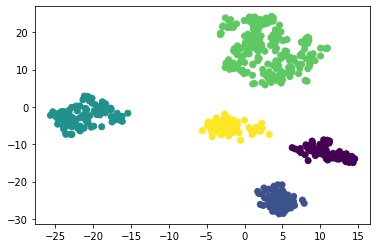

Learning rate: 100


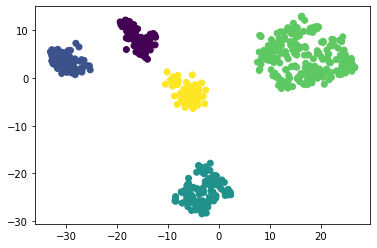

Learning rate: 200


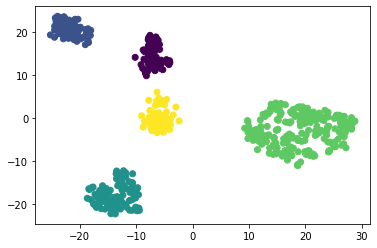

Learning rate: 500


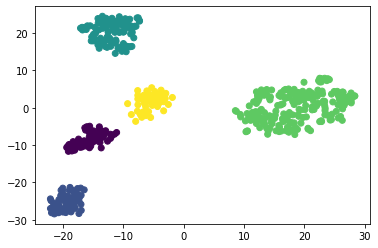

Learning rate: 1000


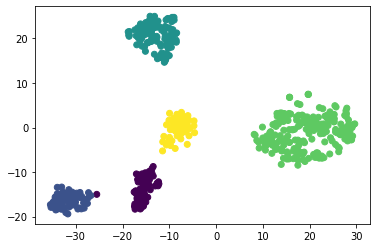

In [94]:
for learning_rate in [10,100,200,500,1000]:
    print("Learning rate:", learning_rate)
    z_tsne = TSNE(n_components=2,perplexity=40, learning_rate=learning_rate).fit_transform(z[:,0:50])
    plt.scatter(z_tsne[:,0],z_tsne[:,1], c=y)
    plt.show()

Learning rate: 10


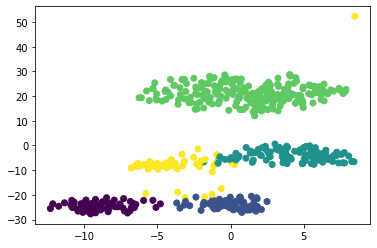

Learning rate: 100


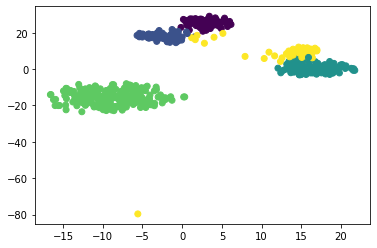

Learning rate: 200


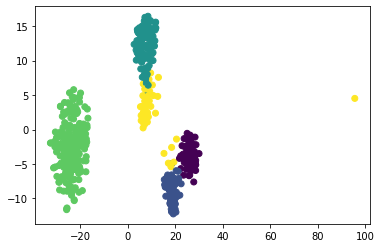

Learning rate: 500


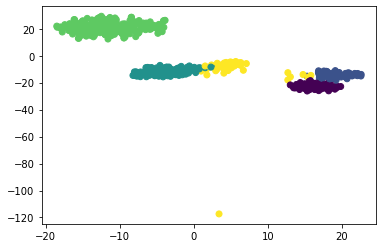

Learning rate: 1000


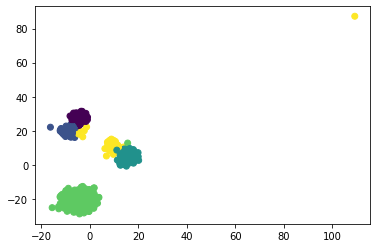

In [95]:
for learning_rate in [10,100,200,500,1000]:
    print("Learning rate:", learning_rate)
    z_tsne = TSNE(n_components=2,perplexity=40, learning_rate=learning_rate).fit_transform(z[:,0:100])
    plt.scatter(z_tsne[:,0],z_tsne[:,1], c=y)
    plt.show()

But if we increase the number of iterations to 3000 instead of the default 1000, the behavior is more consistent across learning rates. The image for learning rate 1000 above is most representative of the optimum of this optimization, and lower learning rate optimizations were stopped too early.

Learning rate: 10


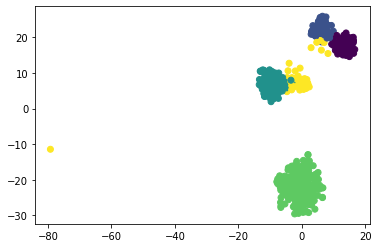

Learning rate: 200


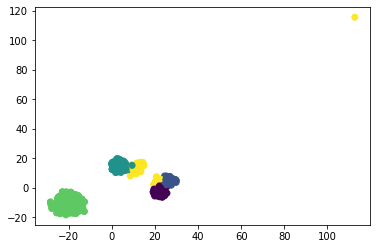

Learning rate: 1000


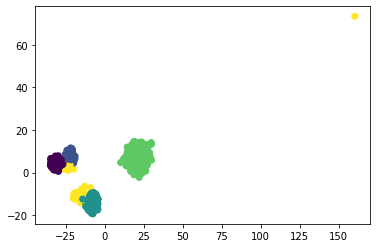

In [99]:
for learning_rate in [10,200,1000]:
    print("Learning rate:", learning_rate)
    z_tsne = TSNE(n_components=2,perplexity=40, n_iter=3000, learning_rate=learning_rate).fit_transform(z[:,0:100])
    plt.scatter(z_tsne[:,0],z_tsne[:,1], c=y)
    plt.show()

# Regularization strength in feature selection

In [17]:
X = np.load("data/p2_unsupervised/X.npy")
X = np.log2(X + 1)

Logistic regression without very small regularization, with labels from before

In [18]:
%%timeit -n 1 -r 1
%%memit -r 1
lr_no_reg = LogisticRegression(penalty="l2",solver="liblinear",C=500)
lr_no_reg.fit(X, labels)

peak memory: 1299.01 MiB, increment: 311.13 MiB
1min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
lr_no_reg.score(X,labels)

1.0

In [23]:
# Get top 100 features by taking features with the largest magnitude coefficients
coef_abs = np.abs(lr_no_reg.coef_)
max_coefs = np.max(coef_abs,axis=0)
features=np.argpartition(max_coefs, -100)[-100:]

Small regularization actually seems to result in more predictive features.

In [26]:
%%timeit -n 1 -r 1
%%memit -r 1
# Train on the evaluation training data, evaluate score on test set
lr2 = LogisticRegressionCV(penalty="l2",solver="liblinear",Cs=[.001,.1,1,5,10,50,100],cv=5).fit(X_train[:,features],y_train)

peak memory: 1776.48 MiB, increment: 2.34 MiB
6.43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [27]:
# Score of this feature selection method
lr2.score(X_test[:,features],y_test)

0.9232851985559567

Large amounts of regularization

In [28]:
%%timeit -n 1 -r 1
%%memit -r 1
lr_no_reg = LogisticRegression(penalty="l2",solver="liblinear",C=1e-3)
lr_no_reg.fit(X, labels)

peak memory: 2073.38 MiB, increment: 301.15 MiB
1min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [29]:
lr_no_reg.score(X,labels)

1.0

In [41]:
# Get top 100 features by taking features with the largest magnitude coefficients
coef_abs = np.abs(lr_no_reg.coef_)
max_coefs = np.max(coef_abs,axis=0)
features=np.argpartition(max_coefs, -100)[-100:]

Having large regularization also seems fine. Using cross-validation actually seemed to make us select features with low variances. This could be because we used the one-vs-rest multi-class method, so for CV, a separate regularization strength can be used for each class. Somehow, this might have caused us to pick lower variance features than if we had a uniform regularization strength.

In [42]:
%%timeit -n 1 -r 1
%%memit -r 1
# Train on the evaluation training data, evaluate score on test set
lr2 = LogisticRegressionCV(penalty="l2",solver="liblinear",Cs=[.001,.1,1,5,10,50,100],cv=5).fit(X_train[:,features],y_train)

peak memory: 1850.11 MiB, increment: 5.14 MiB
8.45 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [43]:
# Score of this feature selection method
lr2.score(X_test[:,features],y_test)

0.9196750902527075

In [49]:
np.setdiff1d(features,features_log_reg)

array([ 2770,  3527,  4331,  4356,  4357,  4511,  4688,  4928,  5523,
        5809,  5810,  5822,  5952,  6626,  6726,  6864,  6951,  7200,
        7473,  7651,  7897,  8451, 15051, 16146, 23379, 24426, 24597,
       25648, 31547, 31662, 31708, 31889, 31924, 33811, 33837, 34467,
       34719, 34844, 34890, 36596, 36601, 36780, 36871, 36892, 37125,
       37456, 37468, 37702, 37968, 38059, 38286, 38611, 39165, 39450,
       39451, 39709, 39723, 40045, 40056, 40469, 40922, 41265, 41386,
       41531, 41533, 41569, 41774, 41790, 41899, 42144, 42860, 42932,
       44094], dtype=int64)

(array([22., 15., 15.,  9.,  5.,  7.,  8.,  6.,  4.,  0.,  3.,  1.,  1.,
         1.,  0.,  0.,  0.,  1.,  0.,  2.]),
 array([ 0.36550794,  1.59034357,  2.8151792 ,  4.04001483,  5.26485046,
         6.48968609,  7.71452171,  8.93935734, 10.16419297, 11.3890286 ,
        12.61386423, 13.83869986, 15.06353549, 16.28837112, 17.51320674,
        18.73804237, 19.962878  , 21.18771363, 22.41254926, 23.63738489,
        24.86222052]),
 <BarContainer object of 20 artists>)

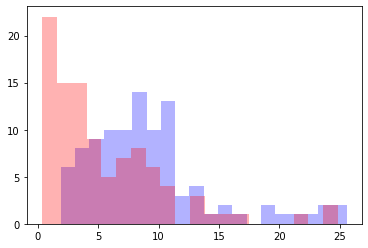

In [51]:
# Histograms of variances of the features selected
variances = np.var(X, axis=0)
plt.hist(variances[features],color="blue",alpha=0.3,bins=20)
plt.hist(variances[features_log_reg],color="red",alpha=0.3,bins=20)